# Supervised, Semi-Supervised, and Unsupervised Learning Analysis

This notebook is part of a broader project comparing different machine learning paradigms on real-world classification tasks.

We first study **supervised**, **semi-supervised (self-training)**, and **unsupervised (k-means and spectral clustering)** methods on the **Breast Cancer Wisconsin (Diagnostic)** dataset, using repeated Monte Carlo splits to obtain stable performance estimates. We then explore **active learning with SVMs** on the **banknote authentication** dataset, comparing query strategies against passive (random) sampling.

All experiments are implemented in Python with `scikit-learn`, and the notebook is organized so that it can be run top-to-bottom for reproducible results.

## Supervised, Semi-Supervised, and Unsupervised Learning

This first section focuses on the Breast Cancer Wisconsin (Diagnostic) dataset. We compare fully supervised L1-penalized SVMs, semi-supervised self-training, and unsupervised clustering (k-means and spectral) using repeated Monte Carlo train/test splits.

### Imports and configuration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils import shuffle
import warnings

warnings.filterwarnings("ignore")

### breast cancer wisconsin (diagnostic) dataset

In [ ]:
columns = ['ID', 'Diagnosis']
features = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 
            'concave_points', 'symmetry', 'fractal_dimension']
for stat in ['_mean', '_se', '_worst']:
    for feature in features:
        columns.append(feature + stat)

df_cancer = pd.read_csv('../data/wdbc.data', header=None, names=columns)
# m=1, b=0
df_cancer['Diagnosis'] = df_cancer['Diagnosis'].map({'M': 1, 'B': 0})
X_cancer = df_cancer.drop(['ID', 'Diagnosis'], axis=1)
y_cancer = df_cancer['Diagnosis']


The Breast Cancer Wisconsin (Diagnostic) dataset contains features extracted from digitized images of fine needle aspirates. Throughout the notebook we standardize the features within each train/test split and reuse the same design matrix \(X\) and label vector \(y\) across the supervised, semi-supervised, and unsupervised experiments.

### monte carlo simulation setup

In [3]:
def calculate_metrics(y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    if y_prob is not None:
        try:
            auc = roc_auc_score(y_true, y_prob)
        except ValueError:
            auc = 0.5
    else:
        auc = roc_auc_score(y_true, y_pred)
    return [acc, prec, rec, f1, auc]

def plot_roc_and_conf_matrix(y_test, y_prob, y_pred, title_prefix):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{title_prefix} ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title_prefix} Confusion Matrix')
    plt.show()

In this baseline, we treat all labels as known and train a **linear SVM with L1 regularization**, tuning the regularization strength \(C\) via cross-validation on each Monte Carlo split. We report average performance (accuracy, precision, recall, F1, ROC AUC) over 30 random train/test splits to quantify how well a fully supervised approach can perform on this dataset.

#### Supervised learning: fully labeled SVM baseline

We simulate a **semi-supervised self-training** scenario by starting with only a subset of labeled points (balanced between malignant and benign). A supervised SVM is first fit on the labeled subset, then iteratively retrained as it pseudo-labels the remaining unlabeled points, always adding the most confident predictions back into the labeled set. This setup tests how close we can get to fully supervised performance when labeled data are limited.

Training Set:


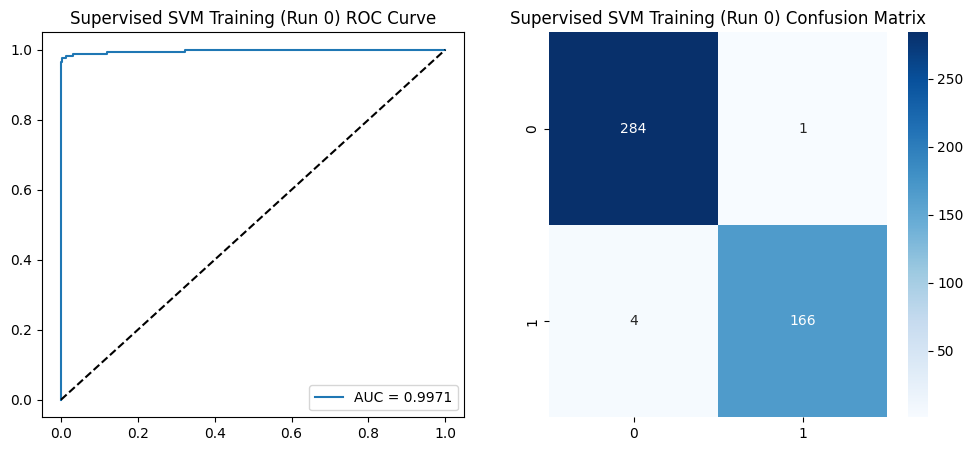

Test Set:


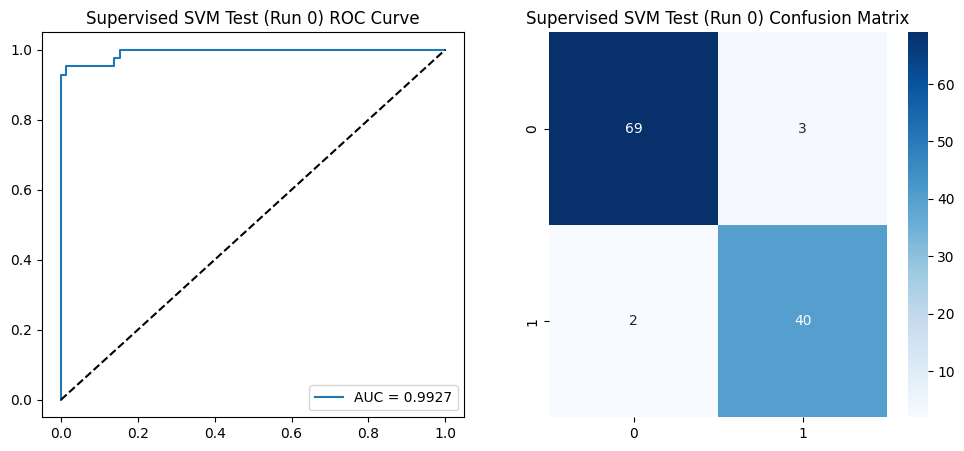


Average Supervised Learning Metrics - Training Set:
Acc     0.985128
Prec    0.990987
Rec     0.969020
F1      0.979856
AUC     0.996922
dtype: float64

Average Supervised Learning Metrics - Test Set:
Acc     0.966667
Prec    0.971559
Rec     0.938095
F1      0.953886
AUC     0.993045
dtype: float64


In [4]:
M = 30
metrics_train_sup = []
metrics_test_sup = []

for m in range(M):
    X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.2, stratify=y_cancer, random_state=m)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # train l1-penalized svm with cv
    params = {'C': np.logspace(-3, 6, 20)}
    svc = LinearSVC(penalty='l1', dual=False, max_iter=2000)
    clf = GridSearchCV(svc, params, cv=5, n_jobs=-1)
    clf.fit(X_train_scaled, y_train)
    
    # evaluate on training set
    y_train_pred = clf.predict(X_train_scaled)
    y_train_prob = clf.decision_function(X_train_scaled)
    metrics_train_sup.append(calculate_metrics(y_train, y_train_pred, y_train_prob))
    
    # evaluate on test set
    y_test_pred = clf.predict(X_test_scaled)
    y_test_prob = clf.decision_function(X_test_scaled)
    metrics_test_sup.append(calculate_metrics(y_test, y_test_pred, y_test_prob))
    
    if m == 0:
        print("Training Set:")
        plot_roc_and_conf_matrix(y_train, y_train_prob, y_train_pred, "Supervised SVM Training (Run 0)")
        print("Test Set:")
        plot_roc_and_conf_matrix(y_test, y_test_prob, y_test_pred, "Supervised SVM Test (Run 0)")

df_sup_train = pd.DataFrame(metrics_train_sup, columns=['Acc', 'Prec', 'Rec', 'F1', 'AUC'])
df_sup_test = pd.DataFrame(metrics_test_sup, columns=['Acc', 'Prec', 'Rec', 'F1', 'AUC'])

print("\nAverage Supervised Learning Metrics - Training Set:")
print(df_sup_train.mean())
print("\nAverage Supervised Learning Metrics - Test Set:")
print(df_sup_test.mean())

#### Semi-supervised learning (self-training)

##### (A)

In [5]:
def prepare_semi_supervised_data(X_train, y_train, random_state=None):
    # select 50% positive and 50% negative for labeled data
    pos_idx = y_train[y_train == 1].index
    neg_idx = y_train[y_train == 0].index
    
    np.random.seed(random_state)
    labeled_pos = np.random.choice(pos_idx, size=int(0.5 * len(pos_idx)), replace=False)
    labeled_neg = np.random.choice(neg_idx, size=int(0.5 * len(neg_idx)), replace=False)
    labeled_idx = np.concatenate([labeled_pos, labeled_neg])
    
    unlabeled_idx = list(set(y_train.index) - set(labeled_idx))
    
    return labeled_idx, unlabeled_idx

X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_cancer, y_cancer, test_size=0.2, stratify=y_cancer, random_state=0)
scaler_A = StandardScaler()
X_train_sc_A = pd.DataFrame(scaler_A.fit_transform(X_train_A), index=X_train_A.index)

lab_idx, unlab_idx = prepare_semi_supervised_data(X_train_A, y_train_A, random_state=0)
X_labeled_A = X_train_sc_A.loc[lab_idx]
y_labeled_A = y_train_A.loc[lab_idx]

params_A = {'C': np.logspace(-3, 6, 20)}
svc_A = LinearSVC(penalty='l1', dual=False, max_iter=2000)
clf_A = GridSearchCV(svc_A, params_A, cv=5, n_jobs=-1)
clf_A.fit(X_labeled_A, y_labeled_A)

,estimator,LinearSVC(dua... penalty='l1')
,param_grid,{'C': array([1.0000...00000000e+06])}
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l1'


Here we apply **k-means clustering** with two clusters on standardized features, without using labels during clustering. After fitting, we assign each cluster a class label based on nearby labeled points and evaluate the resulting classifier using the same metrics as before. This experiment shows how far a purely unsupervised method can go on this task.

##### (B)

Training Set:


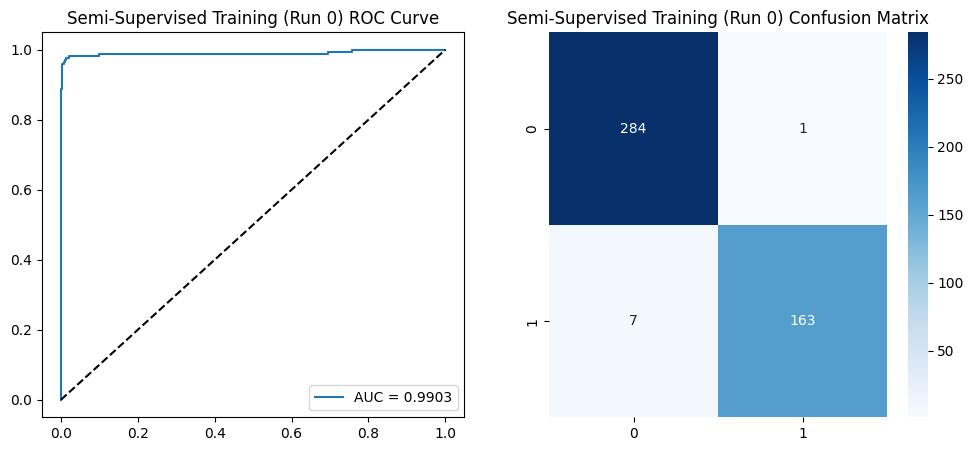

Test Set:


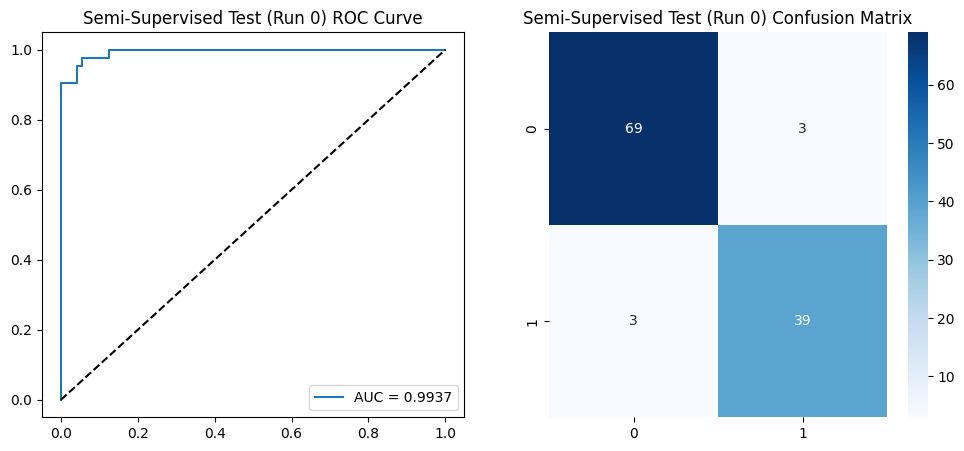


Average Semi-Supervised Metrics - Training Set:
Acc     0.976044
Prec    0.982392
Rec     0.953137
F1      0.967434
AUC     0.993547
dtype: float64

Average Semi-Supervised Metrics - Test Set:
Acc     0.961696
Prec    0.967258
Rec     0.928571
F1      0.946861
AUC     0.991909
dtype: float64


In [6]:
metrics_train_semi = []
metrics_test_semi = []

for m in range(M):
    X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.2, stratify=y_cancer, random_state=m)
    
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index)
    
    lab_idx, unlab_idx = prepare_semi_supervised_data(X_train, y_train, random_state=m)
    X_labeled = X_train_scaled.loc[lab_idx]
    y_labeled = y_train.loc[lab_idx]
    X_unlabeled = X_train_scaled.loc[unlab_idx]
    
    # initial training on labeled data
    params = {'C': np.logspace(-3, 6, 20)}
    svc = LinearSVC(penalty='l1', dual=False, max_iter=2000)
    clf = GridSearchCV(svc, params, cv=5, n_jobs=-1)
    clf.fit(X_labeled, y_labeled)
    model = clf.best_estimator_
    
    # self-training loop
    while len(X_unlabeled) > 0:
        # find farthest data point from hyperplane
        distances = model.decision_function(X_unlabeled)
        farthest_loc = np.argmax(np.abs(distances))
        farthest_idx = X_unlabeled.index[farthest_loc]
        
        pred_label = model.predict(X_unlabeled.loc[[farthest_idx]])
        
        # add to labeled set and retrain
        X_labeled = pd.concat([X_labeled, X_unlabeled.loc[[farthest_idx]]])
        y_labeled = pd.concat([y_labeled, pd.Series(pred_label, index=[farthest_idx])])
        X_unlabeled = X_unlabeled.drop(farthest_idx)
        
        model.fit(X_labeled, y_labeled)
    
    # evaluate on training set
    y_train_pred = model.predict(X_train_scaled)
    y_train_prob = model.decision_function(X_train_scaled)
    metrics_train_semi.append(calculate_metrics(y_train, y_train_pred, y_train_prob))
    
    # evaluate on test set
    y_test_pred = model.predict(X_test_scaled)
    y_test_prob = model.decision_function(X_test_scaled)
    metrics_test_semi.append(calculate_metrics(y_test, y_test_pred, y_test_prob))
    
    if m == 0:
        print("Training Set:")
        plot_roc_and_conf_matrix(y_train, y_train_prob, y_train_pred, "Semi-Supervised Training (Run 0)")
        print("Test Set:")
        plot_roc_and_conf_matrix(y_test, y_test_prob, y_test_pred, "Semi-Supervised Test (Run 0)")

df_semi_train = pd.DataFrame(metrics_train_semi, columns=['Acc', 'Prec', 'Rec', 'F1', 'AUC'])
df_semi_test = pd.DataFrame(metrics_test_semi, columns=['Acc', 'Prec', 'Rec', 'F1', 'AUC'])

print("\nAverage Semi-Supervised Metrics - Training Set:")
print(df_semi_train.mean())
print("\nAverage Semi-Supervised Metrics - Test Set:")
print(df_semi_test.mean())

#### Unsupervised learning (k-means) baseline

##### quick demo run

In [7]:
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_cancer, y_cancer, test_size=0.2, stratify=y_cancer, random_state=42)
scaler_us = StandardScaler()
X_train_sc_us = scaler_us.fit_transform(X_train_us)

kmeans_demo = KMeans(n_clusters=2, n_init=15, random_state=42).fit(X_train_sc_us)

Spectral clustering leverages an RBF kernel similarity graph and an eigen-decomposition of the graph Laplacian to discover non-linearly separable structure. We search over a small grid of kernel width values (gamma) to obtain cluster sizes that roughly match the original class distribution, then assign cluster labels and evaluate performance, again using Monte Carlo splits for stability.

By using n_init=15, k-means runs 15 times with different random initializations and selects the result with the lowest inertia, helping avoid local minima.

##### monte carlo loop

Training Set:


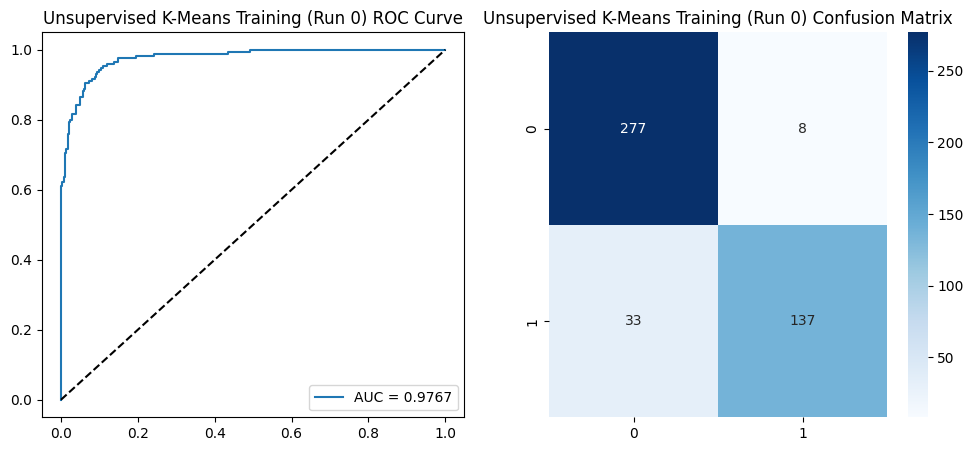

Test Set:


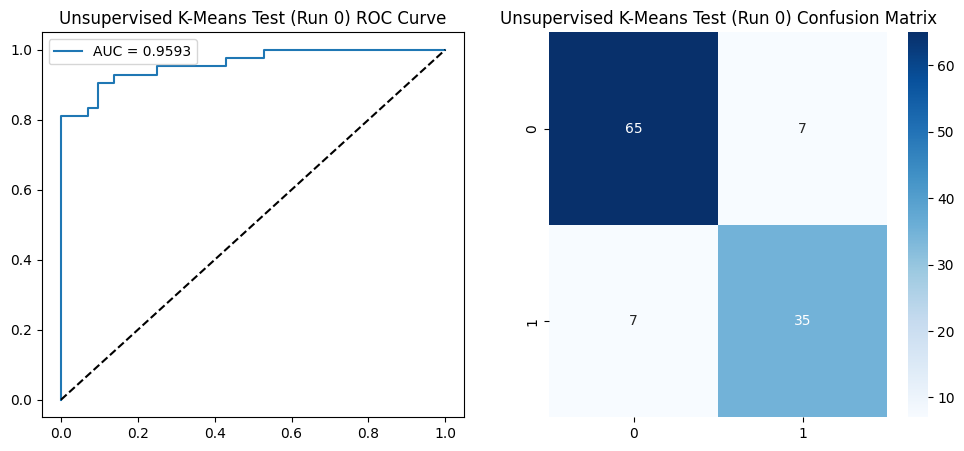


Average Unsupervised Metrics - Training Set:
Acc     0.910256
Prec    0.923679
Rec     0.828627
F1      0.873382
AUC     0.974839
dtype: float64

Average Unsupervised Metrics - Test Set:
Acc     0.905848
Prec    0.909765
Rec     0.827778
F1      0.865621
AUC     0.971847
dtype: float64


In [8]:
metrics_train_unsup = []
metrics_test_unsup = []

def get_kmeans_probabilities(distances, label_c0, label_c1):
    # convert distances to probabilities using softmax
    if label_c0 == 1:
        prob = 1 / (1 + np.exp(distances[:, 0] - distances[:, 1]))
    else:
        prob = 1 / (1 + np.exp(distances[:, 1] - distances[:, 0]))
    return prob

for m in range(M):
    X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.2, stratify=y_cancer, random_state=m)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    kmeans = KMeans(n_clusters=2, n_init=15, random_state=m).fit(X_train_scaled)
    centers = kmeans.cluster_centers_
    
    # label clusters using 30 closest points to each center
    dist_c0 = np.linalg.norm(X_train_scaled - centers[0], axis=1)
    dist_c1 = np.linalg.norm(X_train_scaled - centers[1], axis=1)
    
    closest_c0 = np.argsort(dist_c0)[:30]
    closest_c1 = np.argsort(dist_c1)[:30]
    
    label_c0 = y_train.iloc[closest_c0].mode()[0]
    label_c1 = y_train.iloc[closest_c1].mode()[0]
    
    # predict training set
    train_labels = kmeans.labels_
    y_train_pred = np.where(train_labels == 0, label_c0, label_c1)
    
    dist_train = kmeans.transform(X_train_scaled)
    y_train_prob = get_kmeans_probabilities(dist_train, label_c0, label_c1)
    
    metrics_train_unsup.append(calculate_metrics(y_train, y_train_pred, y_train_prob))
    
    # predict test set
    test_labels = kmeans.predict(X_test_scaled)
    y_test_pred = np.where(test_labels == 0, label_c0, label_c1)
    
    dist_test = kmeans.transform(X_test_scaled)
    y_test_prob = get_kmeans_probabilities(dist_test, label_c0, label_c1)
    
    metrics_test_unsup.append(calculate_metrics(y_test, y_test_pred, y_test_prob))
    
    if m == 0:
        print("Training Set:")
        plot_roc_and_conf_matrix(y_train, y_train_prob, y_train_pred, "Unsupervised K-Means Training (Run 0)")
        print("Test Set:")
        plot_roc_and_conf_matrix(y_test, y_test_prob, y_test_pred, "Unsupervised K-Means Test (Run 0)")

df_unsup_train = pd.DataFrame(metrics_train_unsup, columns=['Acc', 'Prec', 'Rec', 'F1', 'AUC'])
df_unsup_test = pd.DataFrame(metrics_test_unsup, columns=['Acc', 'Prec', 'Rec', 'F1', 'AUC'])

print("\nAverage Unsupervised Metrics - Training Set:")
print(df_unsup_train.mean())
print("\nAverage Unsupervised Metrics - Test Set:")
print(df_unsup_test.mean())

#### Spectral clustering

Training Set:


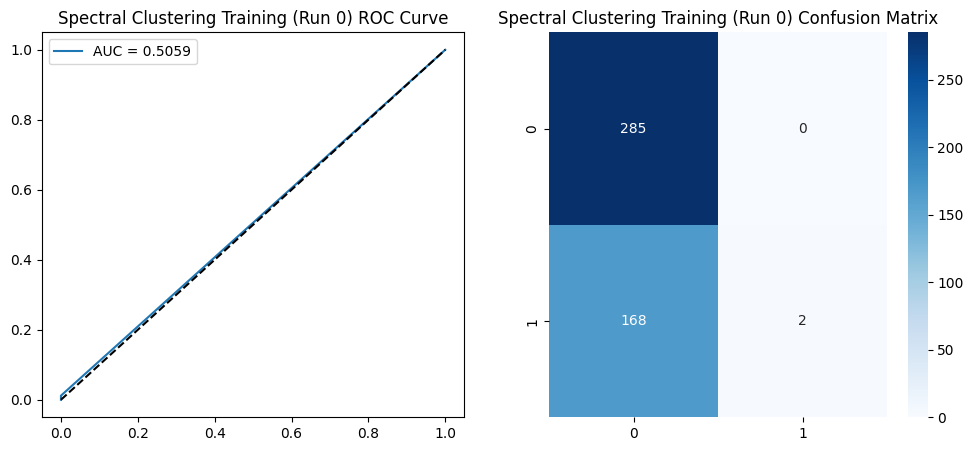

Test Set:


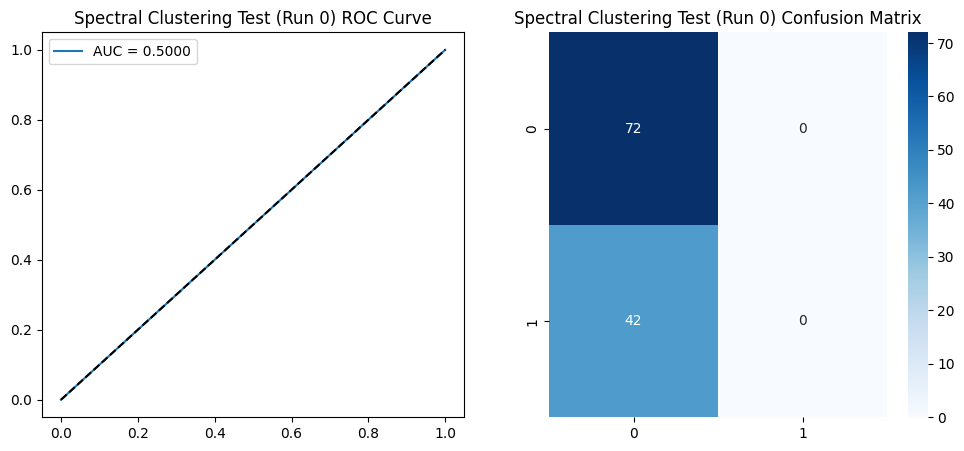


Average Spectral Clustering Metrics - Training Set:
Acc     0.707912
Prec    0.999074
Rec     0.218824
F1      0.282457
AUC     0.641732
dtype: float64

Average Spectral Clustering Metrics - Test Set:
Acc     0.700585
Prec    0.366667
Rec     0.187302
F1      0.247079
AUC     0.643970
dtype: float64


In [ ]:
metrics_train_spec = []
metrics_test_spec = []

def find_balanced_gamma(X_train_scaled, y_train, gamma_range=[0.1, 0.5, 1.0, 2.0, 5.0]):
    """find gamma that gives balanced clusters matching original class distribution"""
    pos_count = np.sum(y_train == 1)
    neg_count = np.sum(y_train == 0)
    target_ratio = pos_count / (pos_count + neg_count)
    
    best_gamma = 1.0
    best_diff = float('inf')
    
    for gamma in gamma_range:
        try:
            spectral = SpectralClustering(n_clusters=2, affinity='rbf', gamma=gamma, 
                                        assign_labels='kmeans', random_state=42, n_init=10)
            labels = spectral.fit_predict(X_train_scaled)
            cluster_0_ratio = np.sum(labels == 0) / len(labels)
            diff = abs(cluster_0_ratio - target_ratio)
            if diff < best_diff:
                best_diff = diff
                best_gamma = gamma
        except:
            continue
    
    return best_gamma

for m in range(M):
    X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.2, 
                                                         stratify=y_cancer, random_state=m)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # find appropriate gamma for balanced clusters (consistent for all runs)
    gamma = find_balanced_gamma(X_train_scaled, y_train)
    
    spectral = SpectralClustering(n_clusters=2, affinity='rbf', gamma=gamma, 
                                assign_labels='kmeans', random_state=m, n_init=10)
    labels_train = spectral.fit_predict(X_train_scaled)
    
    # label clusters using all points in each cluster 
    idx_0 = np.where(labels_train == 0)[0]
    idx_1 = np.where(labels_train == 1)[0]
    
    if len(idx_0) > 0:
        lbl_c0 = y_train.iloc[idx_0].mode()[0]  
    else:
        lbl_c0 = 0
    
    if len(idx_1) > 0:
        lbl_c1 = y_train.iloc[idx_1].mode()[0]  
    else:
        lbl_c1 = 1
    
    # predict training set
    y_train_pred = np.where(labels_train == 0, lbl_c0, lbl_c1)
    
    # use knn to get probabilities for roc
    unique_classes = np.unique(y_train_pred)
    if len(unique_classes) == 2:
        knn_train = KNeighborsClassifier(n_neighbors=10).fit(X_train_scaled, y_train_pred)
        proba = knn_train.predict_proba(X_train_scaled)
        class_1_idx = np.where(knn_train.classes_ == 1)[0]
        if len(class_1_idx) > 0:
            y_train_prob = proba[:, class_1_idx[0]]
        else:
            y_train_prob = 1 - proba[:, 0]
    else:
        if unique_classes[0] == 1:
            y_train_prob = np.ones(len(y_train_pred))
        else:
            y_train_prob = np.zeros(len(y_train_pred))
    
    metrics_train_spec.append(calculate_metrics(y_train, y_train_pred, y_train_prob))
    
    # predict test set using knn
    if len(unique_classes) == 2:
        knn_test = KNeighborsClassifier(n_neighbors=10).fit(X_train_scaled, y_train_pred)
        y_test_pred = knn_test.predict(X_test_scaled)
        proba_test = knn_test.predict_proba(X_test_scaled)
        class_1_idx = np.where(knn_test.classes_ == 1)[0]
        if len(class_1_idx) > 0:
            y_test_prob = proba_test[:, class_1_idx[0]]
        else:
            y_test_prob = 1 - proba_test[:, 0]
    else:
        y_test_pred = np.full(len(X_test_scaled), unique_classes[0])
        if unique_classes[0] == 1:
            y_test_prob = np.ones(len(X_test_scaled))
        else:
            y_test_prob = np.zeros(len(X_test_scaled))
    
    metrics_test_spec.append(calculate_metrics(y_test, y_test_pred, y_test_prob))
    
    if m == 0:
        print("Training Set:")
        plot_roc_and_conf_matrix(y_train, y_train_prob, y_train_pred, "Spectral Clustering Training (Run 0)")
        print("Test Set:")
        plot_roc_and_conf_matrix(y_test, y_test_prob, y_test_pred, "Spectral Clustering Test (Run 0)")

df_spec_train = pd.DataFrame(metrics_train_spec, columns=['Acc', 'Prec', 'Rec', 'F1', 'AUC'])
df_spec_test = pd.DataFrame(metrics_test_spec, columns=['Acc', 'Prec', 'Rec', 'F1', 'AUC'])

print("\nAverage Spectral Clustering Metrics - Training Set:")
print(df_spec_train.mean())
print("\nAverage Spectral Clustering Metrics - Test Set:")
print(df_spec_test.mean())

#### Comparison of methods on breast cancer data

In this section, we aggregate the Monte Carlo results into a single comparison table for the breast cancer dataset. For each learning paradigm (supervised, semi-supervised self-training, k-means, and spectral clustering), we report the average accuracy, precision, recall, F1, and ROC AUC on both the training and test sets to highlight their relative strengths and weaknesses.

In [ ]:
summary_test = pd.DataFrame({
    'Supervised': df_sup_test.mean(),
    'Semi-Supervised': df_semi_test.mean(),
    'Unsupervised': df_unsup_test.mean(),
    'Spectral': df_spec_test.mean()
})

summary_train = pd.DataFrame({
    'Supervised': df_sup_train.mean(),
    'Semi-Supervised': df_semi_train.mean(),
    'Unsupervised': df_unsup_train.mean(),
    'Spectral': df_spec_train.mean()
})

print("TRAINING SET COMPARISON")
print(summary_train)
print("TEST SET COMPARISON")
print(summary_test)


TRAINING SET COMPARISON
      Supervised  Semi-Supervised  Unsupervised  Spectral
Acc     0.985128         0.976044      0.910256  0.707912
Prec    0.990987         0.982392      0.923679  0.999074
Rec     0.969020         0.953137      0.828627  0.218824
F1      0.979856         0.967434      0.873382  0.282457
AUC     0.996922         0.993547      0.974839  0.641732
TEST SET COMPARISON
      Supervised  Semi-Supervised  Unsupervised  Spectral
Acc     0.966667         0.961696      0.905848  0.700585
Prec    0.971559         0.967258      0.909765  0.366667
Rec     0.938095         0.928571      0.827778  0.187302
F1      0.953886         0.946861      0.865621  0.247079
AUC     0.993045         0.991909      0.971847  0.643970


- **Supervised SVM** on fully labeled breast cancer data achieves the strongest overall performance (roughly 0.97 test accuracy and AUC close to 0.99).
- **Semi-supervised self-training** comes very close to the supervised baseline, even though it starts from only half of the labeled points.
- **Unsupervised k-means** does reasonably well but consistently lags behind methods that explicitly use label information.
- **Spectral clustering** is highly sensitive to hyperparameters and yields weaker, less stable performance on this dataset.
- **Takeaway**: more label information generally improves performance, but semi-supervised learning can recover most of the supervised performance when labeled data are scarce.

## Active learning with support vector machines

In the second part of the notebook, we move to the banknote authentication dataset to study label efficiency. We compare passive learning (random sampling) versus active learning (querying points closest to the SVM hyperplane) by tracking test error as the labeled training set grows.

### Banknote authentication dataset

In [11]:
df_note = pd.read_csv("../data/data_banknote_authentication.txt", header=None, names=['var', 'skew', 'curt', 'ent', 'class'])
X_note = df_note.drop('class', axis=1)
y_note = df_note['class']

# create pool and test set
X_pool, X_test_note, y_pool, y_test_note = train_test_split(X_note, y_note, test_size=472, stratify=y_note, random_state=42)
X_pool.reset_index(drop=True, inplace=True)
y_pool.reset_index(drop=True, inplace=True)

### experiment setup (50 monte carlo runs)

#### passive learning (random sampling)

In [ ]:
runs = 50
steps = 90
passive_errors = np.zeros((runs, steps))

for r in range(runs):
    X_p, y_p = shuffle(X_pool, y_pool, random_state=r)
    X_p = X_p.reset_index(drop=True)
    y_p = y_p.reset_index(drop=True)
    
    # start with 10 random samples
    X_curr = X_p.iloc[:10].copy()
    y_curr = y_p.iloc[:10].copy()
    remaining_indices = list(range(10, len(X_p)))
    
    for i in range(steps):
        # ensure 2 classes in current pool
        while len(np.unique(y_curr)) < 2 and len(remaining_indices) > 0:
            add_idx = np.random.choice(remaining_indices, 1)[0]
            X_curr = pd.concat([X_curr, X_p.iloc[[add_idx]]], ignore_index=True)
            y_curr = pd.concat([y_curr, y_p.iloc[[add_idx]]], ignore_index=True)
            remaining_indices.remove(add_idx)
            
        # train model
        svc = LinearSVC(penalty='l1', dual=False, max_iter=2000)
        try:
            clf = GridSearchCV(svc, {'C': np.logspace(-3, 6, 20)}, cv=min(5, len(X_curr)), n_jobs=-1)
            clf.fit(X_curr, y_curr)
            model = clf.best_estimator_
        except:
            model = LinearSVC(penalty='l1', dual=False, C=1.0, max_iter=2000).fit(X_curr, y_curr)
            
        passive_errors[r, i] = 1 - model.score(X_test_note, y_test_note)
        
        # add 10 random samples
        if len(remaining_indices) >= 10:
            add_indices = np.random.choice(remaining_indices, 10, replace=False)
            X_curr = pd.concat([X_curr, X_p.iloc[add_indices]], ignore_index=True)
            y_curr = pd.concat([y_curr, y_p.iloc[add_indices]], ignore_index=True)
            remaining_indices = [idx for idx in remaining_indices if idx not in add_indices]
        elif len(remaining_indices) > 0:
            X_curr = pd.concat([X_curr, X_p.iloc[remaining_indices]], ignore_index=True)
            y_curr = pd.concat([y_curr, y_p.iloc[remaining_indices]], ignore_index=True)
            remaining_indices = []

#### active learning (closest to hyperplane)

In [13]:
active_errors = np.zeros((runs, steps))

for r in range(runs):
    X_p, y_p = shuffle(X_pool, y_pool, random_state=r)
    X_p = X_p.reset_index(drop=True)
    y_p = y_p.reset_index(drop=True)
    
    # start with 10 random samples
    X_curr = X_p.iloc[:10].copy()
    y_curr = y_p.iloc[:10].copy()
    remaining_indices = list(range(10, len(X_p)))
    
    for i in range(steps):
        # ensure 2 classes in current pool
        while len(np.unique(y_curr)) < 2 and len(remaining_indices) > 0:
            add_idx = np.random.choice(remaining_indices, 1)[0]
            X_curr = pd.concat([X_curr, X_p.iloc[[add_idx]]], ignore_index=True)
            y_curr = pd.concat([y_curr, y_p.iloc[[add_idx]]], ignore_index=True)
            remaining_indices.remove(add_idx)
            
        # train model
        svc = LinearSVC(penalty='l1', dual=False, max_iter=2000)
        try:
            clf = GridSearchCV(svc, {'C': np.logspace(-3, 6, 20)}, cv=min(5, len(X_curr)), n_jobs=-1)
            clf.fit(X_curr, y_curr)
            model = clf.best_estimator_
        except:
            model = LinearSVC(penalty='l1', dual=False, C=1.0, max_iter=2000).fit(X_curr, y_curr)
            
        active_errors[r, i] = 1 - model.score(X_test_note, y_test_note)
        
        # add 10 closest to hyperplane
        if len(remaining_indices) >= 10:
            X_rem = X_p.iloc[remaining_indices]
            dists = np.abs(model.decision_function(X_rem))
            closest_idx = np.argsort(dists)[:10]
            add_indices = [remaining_indices[idx] for idx in closest_idx]
            
            X_curr = pd.concat([X_curr, X_p.iloc[add_indices]], ignore_index=True)
            y_curr = pd.concat([y_curr, y_p.iloc[add_indices]], ignore_index=True)
            remaining_indices = [idx for idx in remaining_indices if idx not in add_indices]
        elif len(remaining_indices) > 0:
            X_curr = pd.concat([X_curr, X_p.iloc[remaining_indices]], ignore_index=True)
            y_curr = pd.concat([y_curr, y_p.iloc[remaining_indices]], ignore_index=True)
            remaining_indices = []

### learning curves and averaged test error

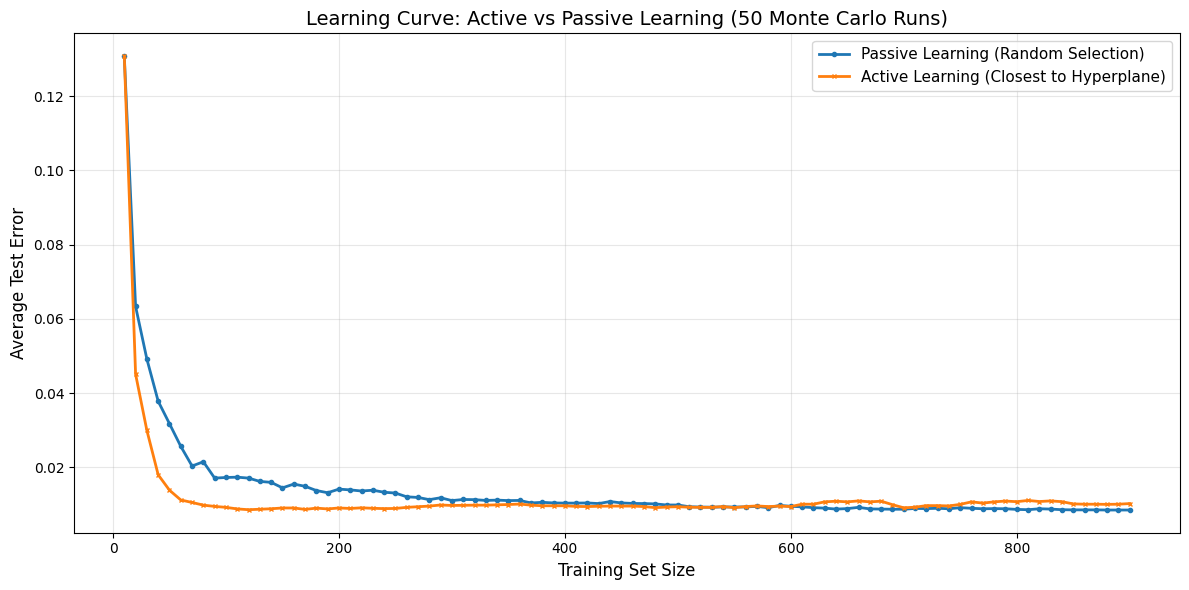

In [14]:
avg_passive = np.mean(passive_errors, axis=0)
avg_active = np.mean(active_errors, axis=0)
x_vals = np.array(range(10, 901, 10))

plt.figure(figsize=(12, 6))
plt.plot(x_vals, avg_passive, label='Passive Learning (Random Selection)', marker='o', markersize=3, linewidth=2)
plt.plot(x_vals, avg_active, label='Active Learning (Closest to Hyperplane)', marker='x', markersize=3, linewidth=2)
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('Average Test Error', fontsize=12)
plt.title('Learning Curve: Active vs Passive Learning (50 Monte Carlo Runs)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

- **Active learning** (querying points closest to the SVM hyperplane) reaches lower test error with fewer labeled samples than passive learning.
- **The benefit is largest when data are scarce**: early in the learning curve, each actively selected point is highly informative.
- **As the training set grows**, passive learning gradually catches up, and both curves become similar.
- **Overall**, active learning is more label-efficient: you achieve comparable test performance while querying substantially fewer labeled examples.

## Conclusions

- **Breast cancer (learning paradigms)**: Fully supervised L1-SVM achieves the strongest performance on the diagnostic task, while semi-supervised self-training recovers most of the supervised accuracy and AUC with only half the initial labels. Unsupervised k-means does surprisingly well for a label-free method, but both k-means and spectral clustering trail the label-using approaches and are more sensitive to initialization and hyperparameters.
- **Banknote authentication (active learning)**: Actively querying points closest to the SVM decision boundary reduces test error faster than random sampling, especially when the labeled dataset is small. As more labels are acquired, passive learning eventually catches up, but active learning remains more label-efficient overall.
- **Takeaway**: When labels are cheap, supervised learning is hard to beat; when labels are scarce or expensive, semi-supervised and active learning strategies can recover much of the supervised performance while using fewer labels.